In [83]:
#lib
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image 
import cv2
import sys
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,InputLayer,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import layers as tfl, optimizers


In [2]:
# 캐글연동
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"blingstarhamal","key":"e1d3d91691d78e6c851bff4c67c1e00e"}'}

In [3]:
ls -1ha kaggle.json

kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json
# 내가 참가한 대회 리스트 확인
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         34           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        144           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        834           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        160           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1978           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13832           False  
house-pr

In [5]:
!kaggle datasets download -d divyansh22/dummy-astronomy-data

 59% 5.00M/8.46M [00:00<00:00, 11.8MB/s]
100% 8.46M/8.46M [00:00<00:00, 19.5MB/s]


In [6]:
!ls

dummy-astronomy-data.zip  kaggle.json  sample_data


In [ ]:
!unzip dummy-astronomy-data.zip

In [62]:
train_data_dir = './Cutout Files'
image_size = (64, 64)

dataset = image_dataset_from_directory(
    train_data_dir,
    image_size=image_size,
)

Found 3986 files belonging to 2 classes.


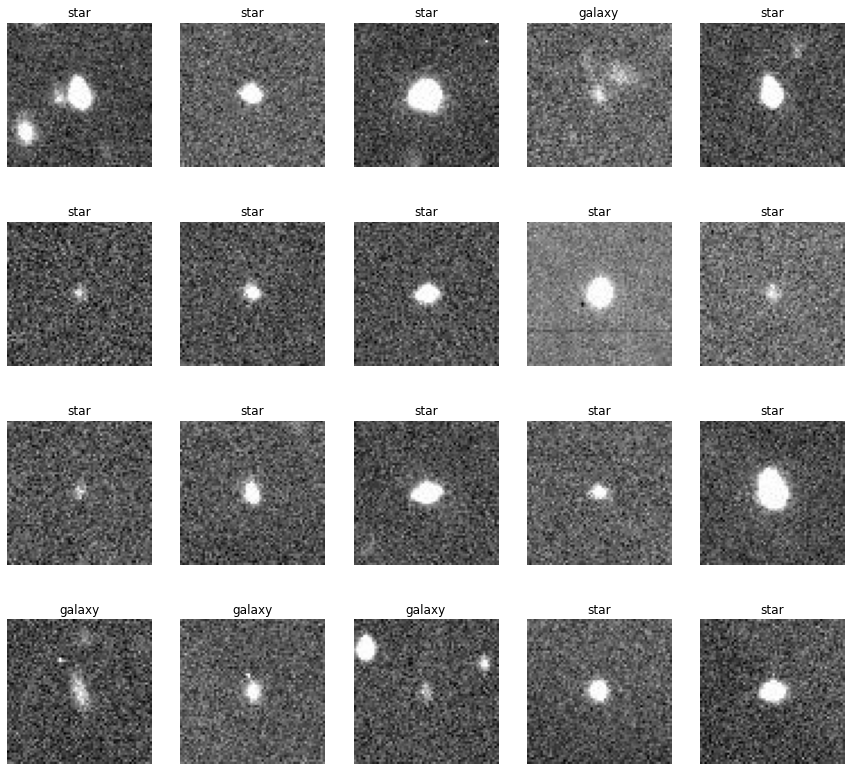

In [63]:
plt.figure(figsize=(15, 25))
class_names = dataset.class_names
for images, labels in dataset.take(1):
    for i in range(20):
        plt.subplot(7, 5, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [64]:
train_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    seed=1,
    subset="training",
    label_mode="categorical",
    image_size=image_size
)

validation_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    seed=1,
    subset="validation",
    label_mode="categorical",
    image_size=image_size
)

Found 3986 files belonging to 2 classes.
Using 3189 files for training.
Found 3986 files belonging to 2 classes.
Using 797 files for validation.


In [57]:
model = Sequential()
model.add(ResNet50(include_top=True, weights=None, input_shape=(64, 64, 3), classes=2))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2)                 23591810  
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [79]:
import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [84]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy', 
    metrics=METRICS
)

In [85]:
epochs = 10
history = model.fit_generator(
    train_dataset, 
    epochs=epochs,
    steps_per_epoch=None, 
    validation_data=validation_dataset,
    validation_steps=None
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


100/100 [==============================] - 13s 69ms/step - loss: 0.7160 - tp: 4856.0000 - fp: 765.0000 - tn: 4856.0000 - fn: 765.0000 - accuracy: 0.8639 - precision: 0.8639 - recall: 0.8639 - auc: 0.9484 - prc: 0.9457 - val_loss: 1351232.3750 - val_tp: 599.0000 - val_fp: 198.0000 - val_tn: 599.0000 - val_fn: 198.0000 - val_accuracy: 0.7516 - val_precision: 0.7516 - val_recall: 0.7516 - val_auc: 0.7516 - val_prc: 0.7132
Epoch 2/10
100/100 [==============================] - 5s 54ms/step - loss: 0.5141 - tp: 2551.0000 - fp: 638.0000 - tn: 2551.0000 - fn: 638.0000 - accuracy: 0.7999 - precision: 0.7999 - recall: 0.7999 - auc: 0.8869 - prc: 0.8833 - val_loss: 23391.5098 - val_tp: 599.0000 - val_fp: 198.0000 - val_tn: 599.0000 - val_fn: 198.0000 - val_accuracy: 0.7516 - val_precision: 0.7516 - val_recall: 0.7516 - val_auc: 0.7516 - val_prc: 0.7132
Epoch 3/10
100/100 [==============================] - 5s 54ms/step - loss: 0.4790 - tp: 2595.0000 - fp: 594.0000 - tn: 2595.0000 - fn: 594.0000 - 

In [71]:
import matplotlib.pyplot as plt

def show_graph(history_dict):
    accuracy = history_dict['acc']
    val_accuracy = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(16, 1))
    
    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy and loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, -0.1))

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, 0))

    plt.show()

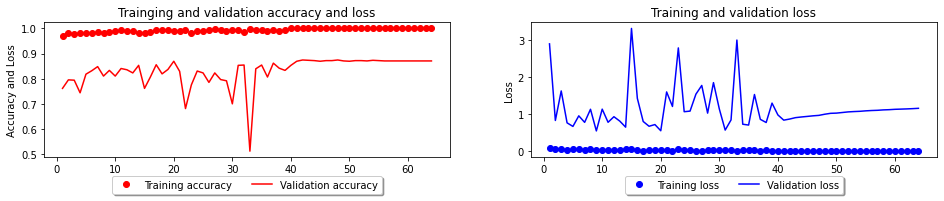

In [72]:
show_graph(history.history)


In [73]:
def smooth_curve(points, factor=.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

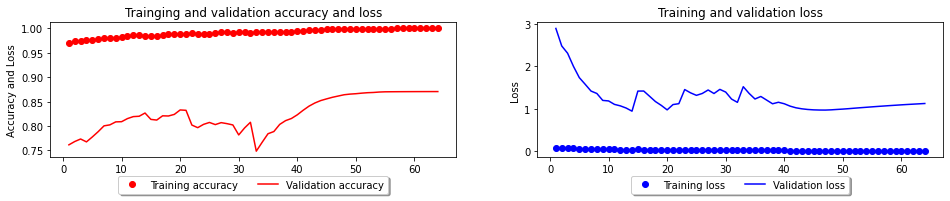

In [74]:
smooth_data = {}
for key, val in history.history.items():
    smooth_data[key] = smooth_curve(val)
show_graph(smooth_data)

In [86]:
training_score= history.history

Text(0.5, 1.0, 'Loss Function')

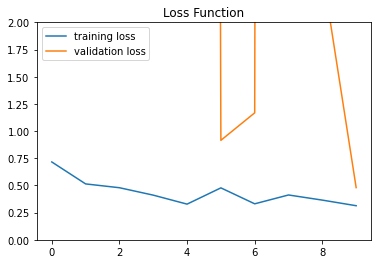

In [87]:
plt.plot(training_score['loss'], label='training loss')
plt.plot(training_score['val_loss'], label='validation loss')
plt.ylim(0,2)
plt.legend()
plt.title('Loss Function')

Text(0.5, 1.0, 'AUC Function')

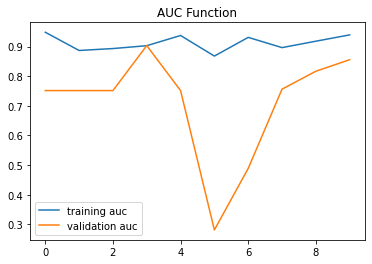

In [88]:
plt.plot(training_score['auc'], label='training auc')
plt.plot(training_score['val_auc'], label='validation auc')
plt.legend()
plt.title('AUC Function')